# IBM Data science Capstone Project

# Predicting an ideal city to migrate, by exploring its neighbourhoods in Canada

## By : Anu Varshini

### Importing the libraries

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from geopy.geocoders import Nominatim
import os
#!pip install folium
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
# machine learning
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
%matplotlib inline

### Downloading and exploring the dataset

To start with lets scrape the list of companies in canada dataset from wikipedia into a dataframe.

In [3]:
table1=pd.read_html('https://en.wikipedia.org/wiki/List_of_companies_of_Canada')
df=table1[1]
df.head()

,Name,Industry,Sector,Headquarters,Founded,Notes
0,1-800-GOT-JUNK?,Industrials,Waste & disposal services,Vancouver,1989,Junk removal
1,Norda Stelo,Industrials,Construction & Materials,Quebec City,1963,Integrated projects
2,3Way International Logistics,Industrials,Business support services,Mississauga,2001,Freight forwarding
3,A Buck or Two,Consumer services,Specialty retailers,Vaughan,1988,Retail
4,A&W,Consumer services,Restaurants & bars,North Vancouver,1956,Fast food chain


In [4]:
df['Headquarters'].value_counts().to_frame().head(10)

,Headquarters
Toronto,91
Vancouver,58
Montreal,52
Winnipeg,31
Calgary,31
Saskatoon,22
Richmond,18
Burnaby,16
Mississauga,16
Ottawa,14


Text(0.5, 1.0, 'Top 5 Industrial locations')

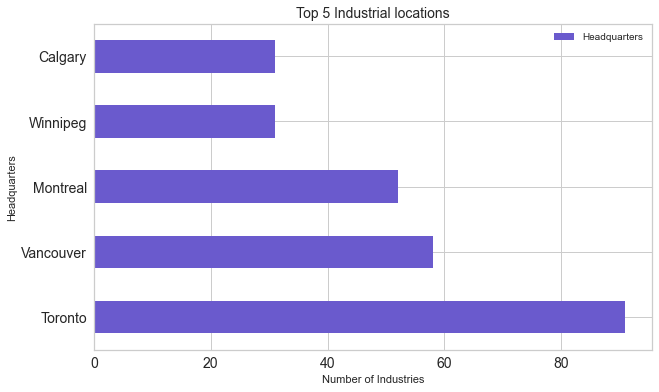

In [5]:
df['Headquarters'].value_counts().to_frame().head(5).plot(kind='barh',figsize=(10,6),color='slateblue')
plt.xlabel('Number of Industries')
plt.ylabel('Headquarters')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Top 5 Industrial locations',fontsize=14)


From the bar plot, Toronto has the highest count of industries followed by Vancouver and Montreal.  Both Calgary and Winnipeg have equal number of industries located within them.

Now let's take a look at the most popular sectors in Canada.

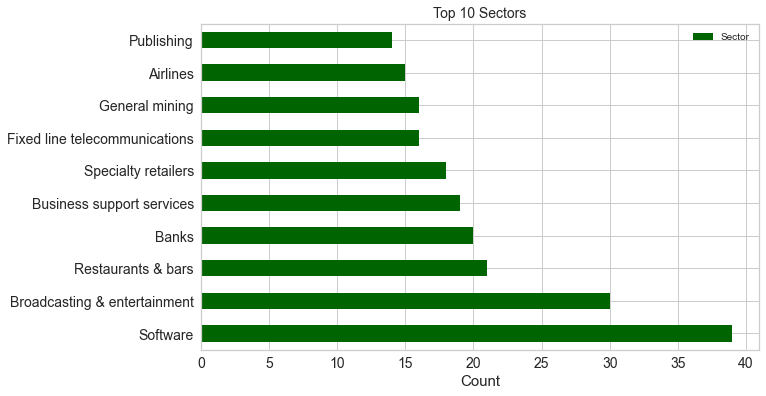

In [6]:
df['Sector'].value_counts().to_frame().head(10).plot(kind='barh',figsize=(10,6),color='darkgreen')
plt.xlabel('Count', fontsize = 15)
plt.title('Top 10 Sectors',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
#displays the plot
plt.show()

Software sector and Broadcasting & entertainment sector are the most popular ones.

Next we will scrape the violent crime severity index per metropolitan area dataset.

In [6]:
table2=pd.read_html('https://en.wikipedia.org/wiki/Crime_in_Canada')
crime_df=table2[1]
crime_df.head()

CMAs in Canada – Violent Crime Severity Index, by year[13][14][15][16][17][18][19][20]  \
                                                                                    City   
0                                 Abbotsford–Mission                                       
1                                             Barrie                                       
2                                          Brantford                                       
3                                            Calgary                                       
4                                           Edmonton                                       

                                                        
    2016   2015  2014  2013  2012   2011   2010   2009  
0   82.3   90.4  81.1  70.7  79.7   72.4   89.8  118.8  
1   46.3   43.8  42.3  38.6  46.1   49.2   50.1   53.9  
2   88.4   70.0  73.5  73.9  67.6   84.5   92.5   91.5  
3   61.3   72.1  63.0  62.0  61.2   72.1   82.1   84.8  
4  102.5  103.9  93.3  89.7  95.8  105.9  106.0  118.7

Next we clean the dataframe by setting proper names to the columns. Taking all the crime data from the years 2009 to 2016(latest available) wouldn’t be advisable as it is very outdated and can affect our analysis. So lets consider the mean of only the years 2015 & 2016.  

In [7]:
# setting the name of the columns
crime_df.columns=['City','2016','2015','2014','2013','2012','2011','2010','2009']
# lets take the average of values from last two years- 2015 & 2016
crime_df['Crime index']=(crime_df['2016']+crime_df['2015'])/2
# drop the remaining columns
crime_df.drop(columns=['2016','2015','2014','2013','2012','2011','2010','2009'],inplace=True)
# drop value in index 33 as it show data for total canada
crime_df.drop(33,inplace=True)
# sort values by ascending and display first five values
crime_df.sort_values(by='Crime index',ascending=False).head()

,City,Crime index
32,Winnipeg,135.85
26,Thunder Bay,122.40
19,Regina,116.00
22,Saskatoon,113.75
4,Edmonton,103.20


These are the cities with the highest crime rates in canada.

Next we will download the quality of life index data into a dataframe.

In [8]:
table3=pd.read_html('https://www.numbeo.com/quality-of-life/country_result.jsp?country=Canada')
quality=table3[4]
quality=quality.iloc[:,1:3]
quality.head()

,City,Quality of Life Index
0,Victoria,187.51
1,Quebec City,179.68
2,Calgary,177.05
3,Vancouver,175.97
4,Ottawa,175.32


In order to narrow down our search for the best city, let’s take into account of only the top 5 cities that has the highest industrial count.

In [9]:
industry_5=df['Headquarters'].value_counts().to_frame().head()
industry_5=industry_5.reset_index()
industry_5.columns=['City','Industrial_count']
industry_5

,City,Industrial_count
0,Toronto,91
1,Vancouver,58
2,Montreal,52
3,Calgary,31
4,Winnipeg,31


we next merge the dataframe above with the crime index dataframe.

In [10]:
# merging the crime data 
top5_safest=pd.merge(industry_5,crime_df,how='inner',on=['City','City'])
top5_safest

,City,Industrial_count,Crime index
0,Toronto,91,67.50
1,Vancouver,58,78.90
2,Montreal,52,74.60
3,Calgary,31,66.70
4,Winnipeg,31,135.85


The resulting dataframe is then merged with the quality of index data.

In [11]:
# Merging the quality index data
top_5=pd.merge(top5_safest,quality,how='inner',on=['City','City'])
top_5

,City,Industrial_count,Crime index,Quality of Life Index
0,Toronto,91,67.50,148.80
1,Vancouver,58,78.90,175.97
2,Montreal,52,74.60,155.37
3,Calgary,31,66.70,177.05
4,Winnipeg,31,135.85,141.57


Now lets sort the dataframe such that it has the lowest crime index and highest quality of life index.

In [12]:
# Now we want the city with low crime index and high quality of life index
top_5.sort_values(['Crime index','Quality of Life Index','Industrial_count'],ascending=[True,False,False])

,City,Industrial_count,Crime index,Quality of Life Index
3,Calgary,31,66.70,177.05
0,Toronto,91,67.50,148.80
2,Montreal,52,74.60,155.37
1,Vancouver,58,78.90,175.97
4,Winnipeg,31,135.85,141.57


Now lets visualize the above dataframe.

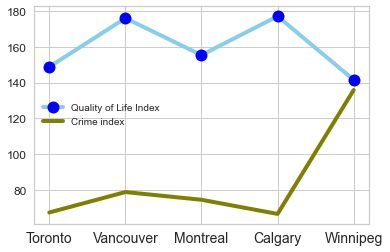

In [13]:
plt.plot( 'City', 'Quality of Life Index', data=top_5, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'City', 'Crime index', data=top_5,marker='', color='olive', linewidth=4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.legend()


### Clearly, Calgary has the lowest crime index and highest quality of life index among the top 5 Industrial cities

To obtain the latitude and longitude of Calgary, we will use the geopy library.

In [14]:
address = 'Calgary,Alberta'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

51.0534234 -114.0625892


Assigning these values.

In [15]:
latitude=51.0534234
longitude=-114.0625892

Now lets get the postal codes of calgary from wikipedia. Calgary comes under the province, Alberta. So lets filter out only the borough calgary

In [16]:
# reading the data from wikipedia
table4=pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_T')
Calgary=table4[1]
# filtering out and keeping only the calgary borough
calgary_df=Calgary[Calgary['Borough']=='Calgary']
# droppping the row due to missing data
calgary_df=calgary_df.drop(119)
calgary_df.reset_index(drop=True,inplace=True)
print(calgary_df.shape)
calgary_df.head()

(34, 5)


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
1,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
2,T2B,Calgary,"Forest Lawn, Dover, Erin Woods",51.0318,-113.9786
3,T3B,Calgary,"Montgomery, Bowness, Silver Springs, Greenwood",51.0809,-114.1616
4,T2C,Calgary,"Lynnwood Ridge, Ogden, Foothills Industrial, G...",50.9878,-114.0001


In [17]:
# checking for the datatypes
calgary_df.dtypes

Postal Code     object
Borough         object
Neighborhood    object
Latitude        object
Longitude       object
dtype: object

Here the Latitude and the Longitude values are specified as objects. They should be converted to float.

In [18]:
calgary_df['Latitude']=calgary_df['Latitude'].astype(float)
calgary_df['Longitude']=calgary_df['Longitude'].astype(float)

Since our data already contains the latitude and longitude data we can go ahead and visualize the geographic details of Calgary and its neighbourhood using the folium library. 

In [19]:
map_calgary = folium.Map(location=[latitude, longitude], zoom_start=11)
# adding calgary lat and long to the map
folium.CircleMarker(
    [51.0534234, -114.0625892],
    radius=10,
    popup='Calgary',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.4
    ).add_to(map_calgary)
# add markers to map
for lat, lng, label in zip(calgary_df['Latitude'], calgary_df['Longitude'], calgary_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='darkgreen',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_calgary)  
    
map_calgary

Next we will use the FourSquare API to get the list of the venues in each neighbourhood of Calgary within 1000 meter radius and set the limit to 100 venues (popular spots) per neighbourhood given their latitude and longitude data.

In [20]:
CLIENT_ID='ENWAHUDQ44EITPRO55ISGGOLWFVQ2K3UOB5ZPDYYHACS4JG4'
CLIENT_SECRET='4GVUR4MSGYTI1NDQJOW13HJZ4ZFQXLM1LC4C4LFPEN2P3X2Z'
LIMIT=100
VERSION='20180605'
radius=1000

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
calgary_venues = getNearbyVenues(names=calgary_df['Neighborhood'],
                                   latitudes=calgary_df['Latitude'],
                                   longitudes=calgary_df['Longitude']
                                  )

Penbrooke Meadows, Marlborough
Dalhousie, Edgemont, Hamptons, Hidden Valley
Forest Lawn, Dover, Erin Woods
Montgomery, Bowness, Silver Springs, Greenwood
Lynnwood Ridge, Ogden, Foothills Industrial, Great Plains
Rosscarrock, Westgate, Wildwood, Shaganappi, Sunalta
Bridgeland, Greenview, Zoo, YYC
Lakeview, Glendale, Killarney, Glamorgan
Inglewood, Burnsland, Chinatown, East Victoria Park, Saddledome
Hawkwood, Arbour Lake, Citadel, Ranchlands, Royal Oak, Rocky Ridge
Highfield, Burns Industrial
Discovery Ridge, Signal Hill, West Springs, Christie Estates, Patterson, Cougar Ridge
Queensland, Lake Bonavista, Willow Park, Acadia
Martindale, Taradale, Falconridge, Saddle Ridge
Thorncliffe, Tuxedo Park
Sandstone, MacEwan Glen, Beddington, Harvest Hills, Coventry Hills, Panorama Hills
Brentwood, Collingwood, Nose Hill
Tuscany, Scenic Acres
Mount Pleasant, Capitol Hill, Banff Trail
Cranston, Auburn Bay, Mahogany
Kensington, Westmont, Parkdale, University
Northeast Calgary
City Centre, Calgary To

TThe name of the venue, the category it belongs to, and the geographical data such as venue latitude and longitude returned by the Foursquare API are added to the dataframe

In [23]:
print(calgary_venues.shape)
calgary_venues.head(10)

(337, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158,Petro-Canada,51.128068,-114.138057,Gas Station
1,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158,Edgemont City,51.126473,-114.138997,Asian Restaurant
2,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158,Friends Cappuccino Bar & Bake Shop,51.126370,-114.138676,Café
3,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158,Mac's,51.128309,-114.137902,Convenience Store
4,"Forest Lawn, Dover, Erin Woods",51.03180,-113.978600,Bonasera Pizza And Sports Bar,51.029893,-113.982543,Bar
5,"Forest Lawn, Dover, Erin Woods",51.03180,-113.978600,7-Eleven,51.029839,-113.982060,Convenience Store
6,"Forest Lawn, Dover, Erin Woods",51.03180,-113.978600,Hempisphere,51.031206,-113.981848,Smoke Shop
7,"Forest Lawn, Dover, Erin Woods",51.03180,-113.978600,Foggy Gorilla Vaping Co.,51.030038,-113.972642,Smoke Shop
8,"Montgomery, Bowness, Silver Springs, Greenwood",51.08090,-114.161600,Starbucks,51.084185,-114.156905,Coffee Shop
9,"Montgomery, Bowness, Silver Springs, Greenwood",51.08090,-114.161600,Dale Hodges Park Lookout,51.080653,-114.166324,Scenic Lookout


Now let's explore the most common venues in these neighborhoods with the help of a wordcloud.

In [24]:
from wordcloud import WordCloud

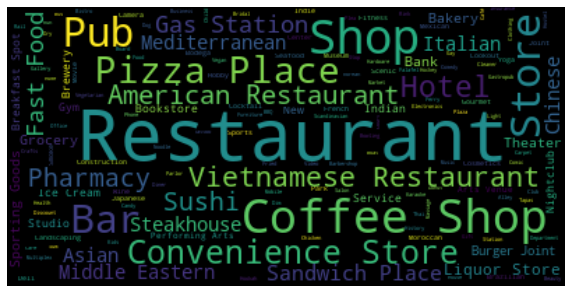

In [25]:
wordcloud = WordCloud().generate(' '.join(calgary_venues['Venue Category']))
fig = plt.figure()
fig.set_figwidth(10) # set width
fig.set_figheight(12)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [26]:
print('There are {} uniques categories.'.format(len(calgary_venues['Venue Category'].unique())))

There are 115 uniques categories.


We can see that there are 115 unique venues in the neighborhood and from the word cloud we can infer that the most popular ones are Restaurants, Coffee shops, Convenience Stores, Bars, Pizza Places and Gas station.

### One hot encoding

Many machine learning algorithms cannot handle categorical data very well. One-Hot Encoding is popular technique for treating categorical variables. It simply creates additional features based on the number of unique values in the categorical feature. Every unique value in the category will be added as a feature. Dummy variables are created for each venue category.

In [27]:
calgary_onehot = pd.get_dummies(calgary_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
calgary_onehot['Neighborhood'] = calgary_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [calgary_onehot.columns[-1]] + list(calgary_onehot.columns[:-1])
calgary_onehot = calgary_onehot[fixed_columns]

calgary_onehot.head()

,Neighborhood,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Bistro,Board Shop,Boat or Ferry,Bookstore,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Bus Stop,Business Service,Café,Camera Store,Candy Store,Carpet Store,Child Care Service,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Falafel Restaurant,Fast Food Restaurant,Flea Market,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,History Museum,Hobby Shop,Hockey Rink,Hookah Bar,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Italian Restaurant,Japanese Restaurant,Karaoke Bar,Kids Store,Korean Restaurant,Light Rail Station,Liquor Store,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Moroccan Restaurant,Multiplex,Museum,Music Store,New American Restaurant,Nightclub,Noodle House,Park,Performing Arts Venue,Pharmacy,Pizza Place,Plaza,Pub,Restaurant,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Smoke Shop,Sporting Goods Shop,Sports Bar,Steakhouse,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Shop,Yoga Studio
0,"Dalhousie, Edgemont, Hamptons, Hidden Valley",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Dalhousie, Edgemont, Hamptons, Hidden Valley",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Dalhousie, Edgemont, Hamptons, Hidden Valley",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Dalhousie, Edgemont, Hamptons, Hidden Valley",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Forest Lawn, Dover, Erin Woods",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now lets group rows by neighborhood and by mean of feaquency of occurence of each category.

In [28]:
calgary_grouped = calgary_onehot.groupby('Neighborhood').mean().reset_index()
print(calgary_grouped.shape)
calgary_grouped.head()

(33, 116)


,Neighborhood,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Bistro,Board Shop,Boat or Ferry,Bookstore,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Bus Stop,Business Service,Café,Camera Store,Candy Store,Carpet Store,Child Care Service,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Falafel Restaurant,Fast Food Restaurant,Flea Market,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,History Museum,Hobby Shop,Hockey Rink,Hookah Bar,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Italian Restaurant,Japanese Restaurant,Karaoke Bar,Kids Store,Korean Restaurant,Light Rail Station,Liquor Store,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Moroccan Restaurant,Multiplex,Museum,Music Store,New American Restaurant,Nightclub,Noodle House,Park,Performing Arts Venue,Pharmacy,Pizza Place,Plaza,Pub,Restaurant,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Smoke Shop,Sporting Goods Shop,Sports Bar,Steakhouse,Sushi Restaurant,Tapas Restaurant,Tattoo Parlor,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Shop,Yoga Studio
0,"Braeside, Cedarbrae, Woodbine",0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.111111,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.111111,0.0,0.0,0.00000,0.000000,0.000000,0.111111,0.000000,0.0,0.0,0.00000,0.000000,0.111111,0.0,0.0,0.00000,0.111111,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.111111,0.111111,0.0,0.111111,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000
1,"Brentwood, Collingwood, Nose Hill",0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000
2,"Bridgeland, Greenview, Zoo, YYC",0.0,0.0,0.0,0.045455,0.0,0.000000,0.045455,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.045455,0.0,0.0,0.000000,0.0,0.0,0.0,0.045455,0.0,0.0,0.0,0.045455,0.0,0.0,0.0,0.00000,0.0,0.0,0.045455,0.090909,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.045455,0.000000,0.045455,0.0,0.0,0.00000,0.045455,0.000000,0.0,0.0,0.00000,0.000000,0.045455,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.045455,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.045455,0.0,0.0,0.045455,0.000000,0.0,0.000000,0.045455,0.00000,0.045455,0.00000,0.045455,0.045455,0.0,0.000000,0.0,0.045455,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,0.0,0.00000
3,"City Centre, Calgary Tower",0.0,0.0,0.0,0.000000,0.0,0.071429,0.000000,0.071429,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.035714,0.0,0.00000

Lets print each neighborhood along with the top 5 most common venues

In [29]:
num_top_venues = 5

for hood in calgary_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = calgary_grouped[calgary_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Braeside, Cedarbrae, Woodbine----
         venue  freq
0  Gas Station  0.11
1     Pharmacy  0.11
2  Hockey Rink  0.11
3          Gym  0.11
4  Coffee Shop  0.11


----Brentwood, Collingwood, Nose Hill----
                 venue  freq
0    Electronics Store   1.0
1  American Restaurant   0.0
2           Kids Store   0.0
3               Museum   0.0
4            Multiplex   0.0


----Bridgeland, Greenview, Zoo, YYC----
                  venue  freq
0  Fast Food Restaurant  0.09
1  Gym / Fitness Center  0.05
2    Seafood Restaurant  0.05
3     Indian Restaurant  0.05
4         Grocery Store  0.05


----City Centre, Calgary Tower----
                      venue  freq
0  Mediterranean Restaurant  0.07
1                    Bakery  0.07
2               Coffee Shop  0.07
3                       Bar  0.07
4                       Pub  0.07


----Connaught, West Victoria Park----
                       venue  freq
0                Coffee Shop  0.10
1                        Bar  0.07
2  Middle 

Lets put the above into a pandas dataframe.

First, let's write a function to sort the venues in descending order.

In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [31]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = calgary_grouped['Neighborhood']

for ind in np.arange(calgary_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(calgary_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Braeside, Cedarbrae, Woodbine",Pharmacy,Gym,Pub,Gas Station,Coffee Shop,Convenience Store,Hockey Rink,Pizza Place,Ice Cream Shop,Yoga Studio
1,"Brentwood, Collingwood, Nose Hill",Electronics Store,Coffee Shop,Comic Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner
2,"Bridgeland, Greenview, Zoo, YYC",Fast Food Restaurant,Gym / Fitness Center,Seafood Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Convenience Store,Indian Restaurant,Dim Sum Restaurant,Noodle House,Pharmacy
3,"City Centre, Calgary Tower",Pub,Bakery,Mediterranean Restaurant,Restaurant,Bar,Sushi Restaurant,Coffee Shop,Gourmet Shop,Pizza Place,Japanese Restaurant
4,"Connaught, West Victoria Park",Coffee Shop,Bar,Middle Eastern Restaurant,Mediterranean Restaurant,Brewery,Pub,Restaurant,French Restaurant,Yoga Studio,Pharmacy


### Machine Learning

Here we will use the most popular clustering algorithm-Kmeans clustering. Clustering allows us to find groups of similar neighborhoods, neighborhoods that are more related to each other than to neighborhoods in other groups. Lets find the optimal value of k, i.e the number of clusters using the elbow method. The elbow method is a useful graphical tool to estimate the optimal number of clusters k for a given task. Intuitively, we can say that, if k increases, the within-cluster SSE (“distortion”) will decrease. This is because the samples will be closer to the centroids they are assigned to.

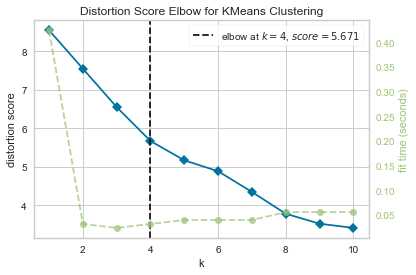

In [32]:
a=calgary_grouped.drop('Neighborhood',1)
model=KMeans()
visualizer=KElbowVisualizer(model,k=(1,11))
visualizer.fit(a)
visualizer.poof()

In [33]:
kclusters = 4

calgary_grouped_clustering = calgary_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=3).fit(calgary_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 0, 0, 0, 0, 1, 1, 0, 0])

In [34]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

calgary_merged = calgary_df

In [35]:
calgary_merged = calgary_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

calgary_merged.head() 

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.04968,-113.964320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158,1.0,Convenience Store,Asian Restaurant,Gas Station,Café,Yoga Studio,Dry Cleaner,Construction & Landscaping,Cosmetics Shop,Deli / Bodega,Department Store
2,T2B,Calgary,"Forest Lawn, Dover, Erin Woods",51.03180,-113.978600,1.0,Smoke Shop,Convenience Store,Bar,Yoga Studio,Electronics Store,Comic Shop,Construction & Landscaping,Cosmetics Shop,Deli / Bodega,Department Store
3,T3B,Calgary,"Montgomery, Bowness, Silver Springs, Greenwood",51.08090,-114.161600,0.0,Scenic Lookout,Bank,Food Court,Coffee Shop,Dry Cleaner,Comic Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega
4,T2C,Calgary,"Lynnwood Ridge, Ogden, Foothills Industrial, G...",50.98780,-114.000100,1.0,Clothing Store,Convenience Store,Pizza Place,Diner,Yoga Studio,Coffee Shop,Comic Shop,Construction & Landscaping,Cosmetics Shop,Deli / Bodega


In [36]:
print(calgary_merged.shape)
calgary_merged=calgary_merged.dropna(subset=['Cluster Labels'])

(34, 16)


### Cluster Visualization

Now lets visualize these clustered neighbourhoods on the map using the folium library. Each cluster is being colour coded for the ease of representation. Its evident that majority of the clusters are marked red, which belongs to the first cluster. Purple markings represent the second cluster. The Blue and Beige markings represent the third and fourth cluster respectively.

In [37]:
import matplotlib.cm as cm
import matplotlib.colors as colors
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(calgary_merged['Latitude'], calgary_merged['Longitude'], calgary_merged['Neighborhood'], calgary_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster Analysis

We have a total of 4 clusters (0,1,2,3). Before we analyze them one by one let's check the total count of neighbourhoods in each cluster

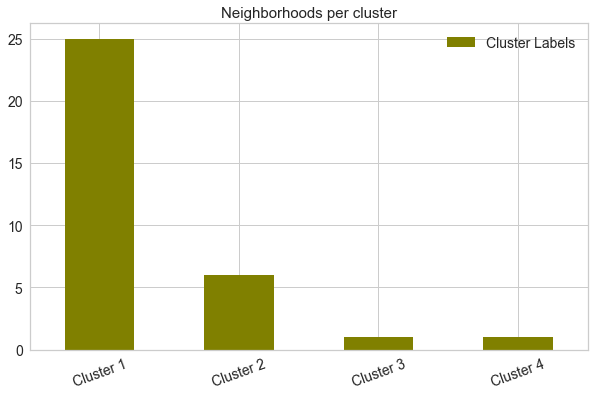

In [71]:
barlist=calgary_merged['Cluster Labels'].value_counts().to_frame().plot(kind='bar',figsize=(10,6),color='olive')
plt.title('Neighborhoods per cluster',fontsize=15)
plt.xticks(fontsize=14,ticks=[0.0,1.0,2.0,3.0],labels=['Cluster 1','Cluster 2','Cluster 3','Cluster 4'],rotation=20)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)


From the bar graph that was made using Matplotlib ,we can compare the number of Neighbourhoods per Cluster.  We see that Cluster 1 has the highest neighbourhoods (25) followed by cluster 2 (6). The Cluster 3 and 4 has only one neighbourhood each.

### Cluster 1

In [38]:
calgary_merged.loc[calgary_merged['Cluster Labels'] == 0, calgary_merged.columns[[1,2] + list(range(5, calgary_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Calgary,"Montgomery, Bowness, Silver Springs, Greenwood",0.0,Scenic Lookout,Bank,Food Court,Coffee Shop,Dry Cleaner,Comic Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega
5,Calgary,"Rosscarrock, Westgate, Wildwood, Shaganappi, S...",0.0,Pub,Sandwich Place,Indian Restaurant,Mexican Restaurant,Sports Bar,Candy Store,Gas Station,Bookstore,Pizza Place,Middle Eastern Restaurant
6,Calgary,"Bridgeland, Greenview, Zoo, YYC",0.0,Fast Food Restaurant,Gym / Fitness Center,Seafood Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Convenience Store,Indian Restaurant,Dim Sum Restaurant,Noodle House,Pharmacy
7,Calgary,"Lakeview, Glendale, Killarney, Glamorgan",0.0,Coffee Shop,Business Service,Wine Shop,Arts & Crafts Store,Falafel Restaurant,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant
8,Calgary,"Inglewood, Burnsland, Chinatown, East Victoria...",0.0,Coffee Shop,Pub,Hotel,Restaurant,Theater,Performing Arts Venue,Cocktail Bar,Deli / Bodega,Steakhouse,New American Restaurant
9,Calgary,"Hawkwood, Arbour Lake, Citadel, Ranchlands, Ro...",0.0,Pizza Place,Pub,Boat or Ferry,Yoga Studio,Donut Shop,Comic Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega
10,Calgary,"Highfield, Burns Industrial",0.0,American Restaurant,Karaoke Bar,Bowling Alley,Electronics Store,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant
12,Calgary,"Queensland, Lake Bonavista, Willow Park, Acadia",0.0,Chinese Restaurant,Child Care Service,Pizza Place,Insurance Office,Yoga Studio,Donut Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega
13,Calgary,"Martindale, Taradale, Falconridge, Saddle Ridge",0.0,Construction & Landscaping,Dog Run,Yoga Studio,Coffee Shop,Comic Shop,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant
15,Calgary,"Sandstone, MacEwan Glen, Beddington, Harvest H...",0.0,Grocery Store,Bank,Liquor Store,Pharmacy,Pizza Place,Italian Restaurant,Coffee Shop,Furniture / Home Store,Diner,Comic Shop


Cluster 1 (Housing Cluster) has a wide variety of venues nearby ranging from restaurants of different cusines to parks and scenic outlooks.It also consists of necessary amenities such as banks, child care, convenience stores, pharmacy and gym. These neighborhoods would be the ideal place for relocating as it also contains good transport network such as Bus stops, Light rail stationa and plenty of gas stations. Also the neighborhoods offer a great night life as Bars, Pubs are located in large numbers.

### Cluster 2

In [39]:
calgary_merged.loc[calgary_merged['Cluster Labels'] == 1, calgary_merged.columns[[1,2] + list(range(5, calgary_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",1.0,Convenience Store,Asian Restaurant,Gas Station,Café,Yoga Studio,Dry Cleaner,Construction & Landscaping,Cosmetics Shop,Deli / Bodega,Department Store
2,Calgary,"Forest Lawn, Dover, Erin Woods",1.0,Smoke Shop,Convenience Store,Bar,Yoga Studio,Electronics Store,Comic Shop,Construction & Landscaping,Cosmetics Shop,Deli / Bodega,Department Store
4,Calgary,"Lynnwood Ridge, Ogden, Foothills Industrial, G...",1.0,Clothing Store,Convenience Store,Pizza Place,Diner,Yoga Studio,Coffee Shop,Comic Shop,Construction & Landscaping,Cosmetics Shop,Deli / Bodega
11,Calgary,"Discovery Ridge, Signal Hill, West Springs, Ch...",1.0,Vietnamese Restaurant,Convenience Store,Gas Station,Bar,Pizza Place,Yoga Studio,Donut Shop,Comic Shop,Construction & Landscaping,Cosmetics Shop
14,Calgary,"Thorncliffe, Tuxedo Park",1.0,Vietnamese Restaurant,Convenience Store,Bar,Fast Food Restaurant,Yoga Studio,Dry Cleaner,Comic Shop,Construction & Landscaping,Cosmetics Shop,Deli / Bodega
23,Calgary,Symons Valley,1.0,Convenience Store,Yoga Studio,Coffee Shop,Comic Shop,Construction & Landscaping,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner


Cluster 2 consists mostly of commercial venues such as convenience stores and clothing stores and can be conveniently named as the Commercial Cluster. These neigborhoods are also hotspots for Vietnamese Cuisine.Thus these neighborhoods would be ideal in order to either set up a store or a vietnamese restaurant. 

### Cluster 3

In [40]:
calgary_merged.loc[calgary_merged['Cluster Labels'] == 2, calgary_merged.columns[[1,2] + list(range(5, calgary_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Calgary,"Brentwood, Collingwood, Nose Hill",2.0,Electronics Store,Coffee Shop,Comic Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner


The third cluster consists of Venues such as Electronics store, Coffee shops and Comic shops.

### Cluster 4

In [41]:
calgary_merged.loc[calgary_merged['Cluster Labels'] == 3, calgary_merged.columns[[1,2] + list(range(5, calgary_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Calgary,Northwest Calgary,3.0,Flea Market,Yoga Studio,Dry Cleaner,Comic Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant


The Fourth cluster consists of Venues such as Flea Market, Dry Cleaner and Yoga Studios.

The third and fourth cluster consisting of one neighbourhood each doesn’t offer much as it has only a few venues such as Electronic stores and Flea markets located within them. This explains the population sparsity of Canada. As these neighbourhoods are not well occupied, they wouldn’t be ideal for migrating.

### Conclusion

The aim of the project is to help the migrants to identify the an ideal place in terms  of safety,  job opportunity , quality of life and choosing a neighbourhood that would be the most suitable for them. Through our analysis we found that Calgary is the best city that fits our criteria. In terms of job opportunity, it is one of the top 5 cities to house  large number of industries.  Also it has low crime rate and high quality of life index. 

With the help of Foursquare API , we then clustered the neighbourhoods of Calgary based on similar neighbourhoods using K-means Algorithm. From our results, the neighbourhoods in the first cluster would be the ideal place to migrate as has a well connected transport system and necessary amenities such as banks, pharmacy, convenience stores and child care. There are also lots of restaurants, bars and scenic outlooks to keep as entertained. 

This project can further be improved by taking into account an additional city and compare both of them to select which would be more suitable to migrate or by using another machine learning algorithm such as DBSCAN to cluster the neighbourhoods.